<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
from oauth2client.service_account import ServiceAccountCredentials
from sklearn import preprocessing

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import seaborn as sns

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks")
%run EEG_Feature_Extraction.ipynb

In [0]:
#Set up google drive API
os.chdir("/content/drive/My Drive/EEG Data")
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)
client = gspread.authorize(creds)

# **Descriptive Statistics**

##**Demographics**

In [0]:
dict = {'sex': ['male', 'female', 'female', 'female', 'female', 'female', 'female', 'female'],
        'ages':[63, 60, 66, 68, 72, 74, 61, 64],
        'group': [0,1,1,0,1,1,0,0]} #0 = Risk Free, 1 = At risk

In [5]:
demo = pd.DataFrame(data = dict)
demo

,sex,ages,group
0,male,63,0
1,female,60,1
2,female,66,1
3,female,68,0
4,female,72,1
5,female,74,1
6,female,61,0
7,female,64,0


##**Cognitive Markers**


In [0]:
gsheet_MoCA = client.open("MoCA DATA").sheet1
gsheet_FCSRT = client.open("FCSRT DATA").sheet1
list_MoCA = gsheet_MoCA.get_all_records()
list_FCSRT = gsheet_FCSRT.get_all_records()

In [0]:
os.chdir('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA')
FCSRT = pd.read_csv('FCSRT.csv')
MoCA = pd.read_csv('MoCA.csv')

MoCA = pd.concat([demo, MoCA], axis = 1).drop(['NAME','SEX','AGE'], axis = 1)
CogMarkers = pd.concat([demo, FCSRT, MoCA[['MoCA']]], axis = 1)
CogMarkers['group'] = CogMarkers['group'].astype('category')
CogMarkers.set_index('id', inplace = True)

CogMarkers['IR-TotalR'] = CogMarkers['IR-FreeR']+CogMarkers['IR-CuedR']
CogMarkers['DL-TotalR'] = CogMarkers['DL-FreeR']+CogMarkers['DL-CuedR']
#CogMarkers.to_csv('cognitive markers.csv')

In [0]:
CogMarkers = CogMarkers.iloc[[1,3,4,5,6,7], :]

###**1) FCSRT**

* **% Encoded**
  * SOMI 0: > 95.8%
  * SOMI 1: > 95.8%
  * SOMI 2a: > 95.8%
  * SOMI 2b: > 93.75 and < 95.8%
  * SOMI 4: > 68.78 and < 91.67%



In [0]:
#computed from [Total Recall x 100]/16
CogMarkers['%Encoded'] = ((CogMarkers['IR-FreeR']+CogMarkers['IR-CuedR'])*100)/16 

*   **% Retrieval**
  * SOMI 0: > 62.5%
  * SOMI 1: > 52.1% and < 62.5%
  * SOMI 2a: > 41.6% and < 50%
  * SOMI 2b: > 41.6% and < 50%
  * SOMI 4: Any


In [0]:
CogMarkers['%Retrieval'] =  CogMarkers['IR-FreeR']*100/16

*   **Classify SS according to SOMI model criteria**


In [0]:
for i in range(-1,7):
  if (CogMarkers.iloc[i, 8] > 95.8) & (CogMarkers.iloc[i, 9] > 62.5):
    CogMarkers['SOMI stage'] = 'SOMI 0'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 52.1) & (CogMarkers.iloc[i, 9] < 62.5):
      CogMarkers['SOMI stage'] = 'SOMI 1'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2a'

  if (CogMarkers.iloc[i, 8] > 93.75) & (CogMarkers.iloc[i, 8] < 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2b'

  if (CogMarkers.iloc[i, 8] > 68.78) & (CogMarkers.iloc[i, 8] < 91.67):
    if CogMarkers.iloc[i, 9] <= 41.6:
      CogMarkers['SOMI stage'] = 'SOMI 4'
  else:
    CogMarkers['SOMI stage'] = 'NaN'

In [0]:
Cog_Normal = CogMarkers[CogMarkers['group'] == 0]
Cog_Risk = CogMarkers[CogMarkers['group'] == 1]

In [0]:
per_cog_risk = Cog_Risk.copy()
per_cog_normal = Cog_Normal.copy()

In [0]:
per_cog_risk['IR-FreeR'] = (Cog_Risk['IR-FreeR']*100)/16
per_cog_risk['IR-CuedR'] = (Cog_Risk['IR-CuedR']*100)/(16-Cog_Risk['IR-FreeR'])
per_cog_risk['DL-FreeR'] = (Cog_Risk['DL-FreeR']*100)/16
per_cog_risk['DL-CuedR'] = (Cog_Risk['DL-CuedR']*100)/(16-Cog_Risk['DL-FreeR'])

per_cog_normal['IR-FreeR'] = (Cog_Normal['IR-FreeR']*100)/16
per_cog_normal['IR-CuedR'] = (Cog_Normal['IR-CuedR']*100)/(16-Cog_Normal['IR-FreeR'])
per_cog_normal['DL-FreeR'] = (Cog_Normal['DL-FreeR']*100)/16
per_cog_normal['DL-CuedR'] = (Cog_Normal['DL-CuedR']*100)/(16-Cog_Normal['DL-FreeR'])



*   **Graph**



In [0]:
def create_plot_df(Normal, Risk):
  plot_risk = Risk.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_risk = plot_risk.transpose()
  plot_risk = plot_risk.reset_index()
  plot_risk['mean'] = plot_risk.mean(axis = 1)

  plot_normal = Normal.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_normal = plot_normal.transpose()
  plot_normal = plot_normal.reset_index()
  plot_normal['mean'] = plot_normal.mean(axis = 1)

  return plot_normal, plot_risk

In [0]:
def plot_markers(plot_data, xlab, ylab, title):
  columns_risk = plot_data.drop(['index', 'mean'], axis = 1)
  title = title

  fig, ax = plt.subplots()
  for subjects in columns_risk:
      ax.plot(plot_data['index'], plot_data[subjects])
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')

  return ax.plot()

In [0]:
def plot_mean_markers(plot_normal, plot_risk, xlab, ylab, title):
  title = title

  fig, ax = plt.subplots()
  ax.plot(plot_risk['index'], plot_risk['mean'], label = 'Risk group', color = 'red')
  ax.plot(plot_normal['index'], plot_normal['mean'], label = 'Normal group', color = 'green')
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.legend()
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')
  return ax.plot()

[]

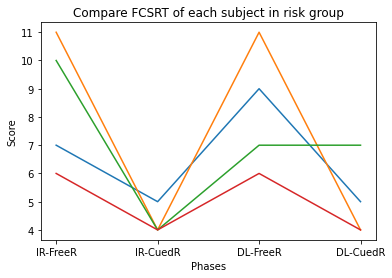

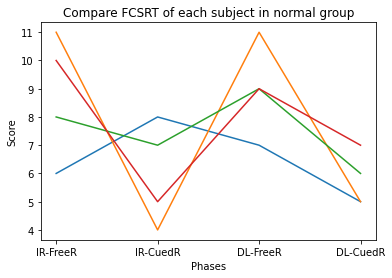

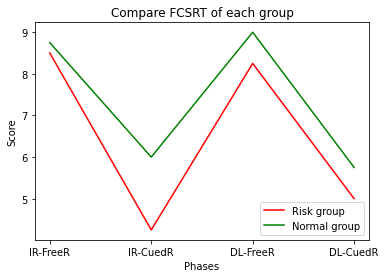

In [0]:
plot_cog_normal, plot_cog_risk = create_plot_df(Cog_Normal, Cog_Risk)
plot_markers(plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each subject in risk group')
plot_markers(plot_cog_normal, 'Phases', 'Score', 'Compare FCSRT of each subject in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each group')

[]

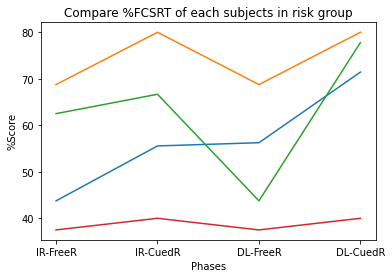

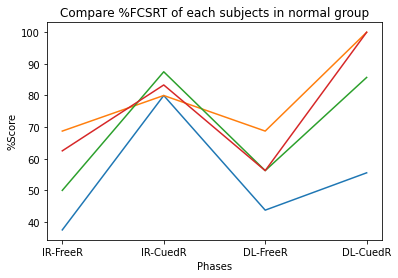

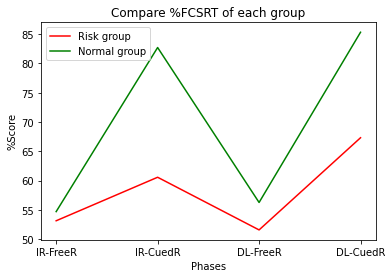

In [0]:
plot_cog_normal, plot_cog_risk = create_plot_df(per_cog_normal, per_cog_risk)
plot_markers(plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each subjects in risk group')
plot_markers(plot_cog_normal, 'Phases', '%Score', 'Compare %FCSRT of each subjects in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each group')

### **2) MoCA**



In [0]:
MoCA_RiskFree = MoCA[MoCA['group'] == 0]
MoCA_Risk = MoCA[MoCA['group'] == 1]

In [0]:
MoCA = MoCA.iloc[[1,3,4,5,6,7], :].copy()
MoCA['group'].replace({0:'Normal', 1:'Risk'}, inplace = True)

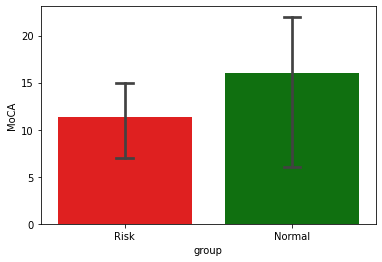

In [71]:
sns.barplot(x = 'group', y = 'MoCA', data = MoCA, capsize = 0.1, palette = ['red', 'green'])

##**Biomarkers**

In [0]:
features = pd.read_csv('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/EEG_features(relative PSD).csv')
features.drop(['id'], inplace = True, axis = 1)
id_group = {'id':['SS2','SS4','SS5','SS6','SS7','SS8'],
            'group':[1,0,1,1,0,0]}
id_group = pd.DataFrame(id_group)
Biomarkers = pd.concat([id_group, features], axis = 1)
Biomarkers.set_index('id', inplace = True)

scaler = preprocessing.MinMaxScaler()
Biomarkers.iloc[:, [6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 26]] = scaler.fit_transform(Biomarkers.iloc[:, [6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 26]])

##**1) PSD**

###**1.1) source PSD x32**
to further run source different analysis



- **Import Data**

In [0]:
os.chdir("/content/drive/My Drive/EEG Data")
#Import Data
IR_psd_normal, DL_psd_normal, WCST_psd_normal = get_psd_sorce(['SS4', 'SS7', 'SS8'])
IR_psd_risk, DL_psd_risk, WCST_psd_risk = get_psd_sorce(['SS2', 'SS5', 'SS6'])

In [0]:
os.chdir('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/PSD Data/Normalize Data (Relative)')
IR_psd_normal = pd.read_csv('IR_psd_normal.csv', index_col = 'bands')
DL_psd_normal = pd.read_csv('DL_psd_normal.csv', index_col = 'bands')
WCST_psd_normal = pd.read_csv('WCST_psd_normal.csv', index_col = 'bands')

IR_psd_risk = pd.read_csv('IR_psd_risk.csv', index_col = 'bands')
DL_psd_risk = pd.read_csv('DL_psd_risk.csv', index_col = 'bands')
WCST_psd_risk = pd.read_csv('WCST_psd_risk.csv', index_col = 'bands')

In [31]:
IR_psd_normal

,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,CP5,P7,P3,Pz,PO3,O1,Oz,O2,PO4,P4,P8,CP6,CP2,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz,id
bands,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
theta,0.350603,0.346808,0.304496,0.318335,0.301117,0.309832,0.199898,0.353506,0.412955,0.324678,0.170902,0.448549,0.318470,0.171713,0.228571,0.282787,0.304316,0.157385,0.154129,0.150545,0.080340,0.252389,0.159443,0.129140,0.090971,0.267092,0.253268,0.182378,0.324395,0.354370,0.331179,0.341374,SS4
delta,4.848627,4.804466,4.467433,4.360240,3.873693,3.925807,2.772481,3.385440,3.045057,3.019356,1.803690,2.687458,1.894932,1.179301,3.663800,2.564949,2.941215,1.867536,2.045350,1.491688,1.331479,2.970198,2.433382,1.705054,1.504560,3.634497,3.780537,3.293821,4.679051,4.806084,4.386445,3.320053,SS4
alpha,4.848627,4.804466,4.467433,4.360240,3.873693,3.925807,2.772481,3.385440,3.045057,3.019356,1.803690,2.687458,1.894932,1.179301,3.663800,2.564949,2.941215,1.867536,2.045350,1.491688,1.331479,2.970198,2.433382,1.705054,1.504560,3.634497,3.780537,3.293821,4.679051,4.806084,4.386445,3.320053,SS4
beta,0.334117,0.351343,0.449957,0.495915,0.700643,0.590424,0.810355,0.811396,0.939354,0.791628,1.035440,1.005976,1.179424,1.141240,0.477130,0.652889,0.912952,1.177212,1.035204,1.021054,1.056437,0.875097,0.870583,0.689226,0.732966,0.628822,0.512588,0.648318,0.350400,0.326135,0.484145,0.810465,SS4
gamma,0.129899,0.193926,0.661740,0.537838,0.533090,0.963191,1.176308,0.865209,0.760122,0.767903,0.665486,0.554651,0.479447,0.787987,0.253056,0.138860,0.215020,0.363771,0.850191,1.521578,1.862204,0.776082,1.438663,1.336163,1.666165,0.845173,0.952508,1.717095,0.374914,0.596236,0.377564,0.397666,SS4
theta,0.188544,0.154909,0.220946,0.130862,0.158807,0.118226,0.081227,0.145940,0.394570,0.209474,0.215492,0.260902,0.312449,0.266372,0.269008,0.236319,0.379354,0.370074,0.379143,0.382721,0.254074,0.243931,0.180467,0.111441,0.112285,0.169517,0.080696,0.233599,0.155069,0.091534,0.144444,0.256545,SS7
delta,1.107379,1.374343,2.908954,1.423768,1.499643,1.184414,1.458565,1.750200,2.471497,2.358993,2.133392,1.996495,2.633012,1.361619,2.358923,3.377899,2.782687,2.815959,2.815092,2.423437,2.582562,2.225290,1.755635,1.009394,1.538533,1.605905,0.995506,2.686239,1.882830,0.947151,1.897532,2.353752,SS7
alpha,1.107379,1.374343,2.908954,1.423768,1.499643,1.184414,1.458565,1.750200,2.471497,2.358993,2.133392,1.996495,2.633012,1.361619,2.358923,3.377899,2.782687,2.815959,2.815092,2.423437,2.582562,2.225290,1.755635,1.009394,1.538533,1.605905,0.995506,2.686239,1.882830,0.947151,1.897532,2.353752,SS7
beta,1.166335,1.259328,0.815065,1.156468,1.120826,0.903637,0.864448,0.774778,1.039194,0.692562,0.985194,1.174602,1.052598,1.159279,1.118172,0.944865,1.105876,1.093638,1.097047,1.066707,0.827579,1.194757,0.912891,0.870406,0.847059,1.008085,0.955644,0.764128,0.850134,1.012029,1.131004,1.150819,SS7


In [0]:
def group_PSD(data):
  by_row_index = data.groupby(data.index)
  data = by_row_index.mean()
  return data

IR_psd_normal = group_PSD(IR_psd_normal)
DL_psd_normal = group_PSD(DL_psd_normal)
WCST_psd_normal = group_PSD(WCST_psd_normal)
IR_psd_risk = group_PSD(IR_psd_risk)
DL_psd_risk= group_PSD(DL_psd_risk)
WCST_psd_risk = group_PSD(WCST_psd_risk)

* **Plot graph**

In [114]:
#Create PSD factor
df = pd.DataFrame(data = None, columns = ['phase', 'channels', 'group', 'PSD', 'bands'], dtype = float)
def concat_PSD(data):
  PSD = []
  PSD_t = []
  for i in range(len(data)):
    PSD = data.iloc[i,:32].values
    PSD_t = np.concatenate((PSD_t, PSD), axis = 0)
  return PSD_t

PSD_IR_normal = concat_PSD(IR_psd_normal) #32x3
PSD_DL_normal = concat_PSD(DL_psd_normal) #32x3
PSD_IR_risk = concat_PSD(IR_psd_risk) #32x3
PSD_DL_risk = concat_PSD(DL_psd_risk) #32x3
PSD = np.concatenate((PSD_IR_normal,PSD_DL_normal,PSD_IR_risk,PSD_DL_risk), axis = 0)
PSD.shape

(1920,)

In [0]:
chn_names = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3',
               'Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8',
               'FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']

In [0]:
group = ['Normal']*960+['Risk']*960
phase = ['IR']*480+['DL']*480+['IR']*480+['DL']*480
ID = ['SS4']*160+['SS7']*160+['SS8']*160+['SS4']*160+['SS7']*160+['SS8']*160+['SS2']*160+['SS5']*160+ ['SS6']*160+['SS2']*160+['SS5']*160+ ['SS6']*160

df['group'] = group
df['phase'] = phase
df['PSD'] = PSD
df['channels'] = chn_names*60

bands = ['theta']*32+['delta']*32+['alpha']*32+['beta']*32+['gamma']*32
bands = bands*12
df['bands'] = bands

In [120]:
df.head()

,phase,channels,group,PSD,bands
0,IR,Fp1,Normal,0.350603,theta
1,IR,AF3,Normal,0.346808,theta
2,IR,F7,Normal,0.304496,theta
3,IR,F3,Normal,0.318335,theta
4,IR,FC1,Normal,0.301117,theta


* For main effect of group

In [0]:
os.chdir('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/PSD Data/Normalize Data (Relative)')

In [0]:
psd_theta = pd.read_csv('theta_PSD.csv')
psd_delta = pd.read_csv('delta_PSD.csv')
psd_alpha = pd.read_csv('alpha_PSD.csv')
psd_beta = pd.read_csv('beta_PSD.csv')
psd_gamma = pd.read_csv('gamma_PSD.csv')

In [92]:
psd_delta.head()

,phase,channels,group,PSD
0,IR,Fp1,Normal,4.848627
1,IR,AF3,Normal,4.804466
2,IR,F7,Normal,4.467433
3,IR,F3,Normal,4.360240
4,IR,FC1,Normal,3.873693


In [0]:
def plot_PSD(data, title):
  plt.subplots(figsize = (18,4))
  sns.lineplot(x = 'channels', y = 'PSD', hue = 'group', data = data, style = 'group', palette = ['green', 'red'])
  plt.ylabel('relative PSD')
  plt.title(title)
  return plt.show()

####**1) Main effect of group**

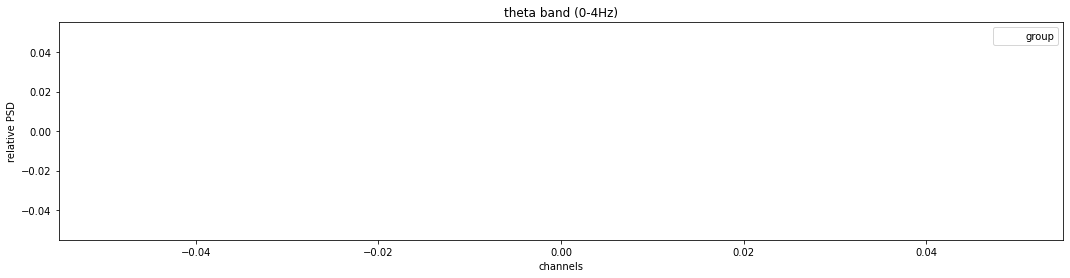

In [88]:
plot_PSD('theta', 'theta band (0-4Hz)')

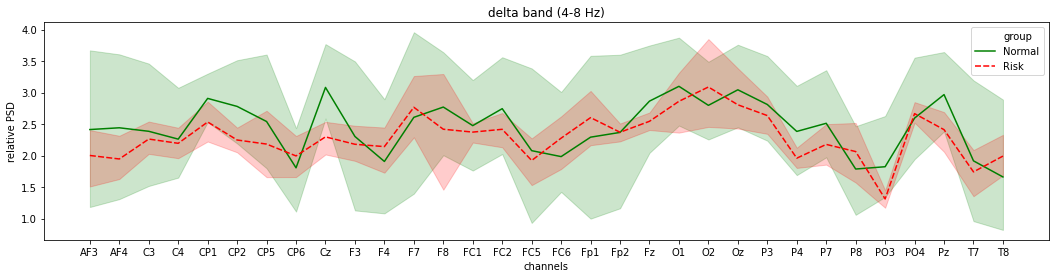

In [101]:
plot_PSD(psd_delta, 'delta band (4-8 Hz)')

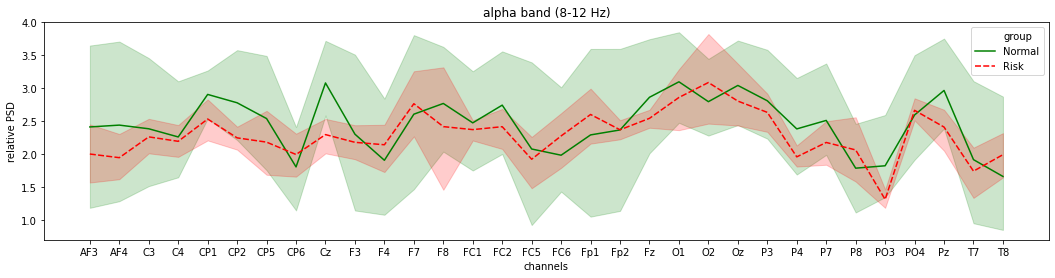

In [102]:
plot_PSD(psd_alpha, 'alpha band (8-12 Hz)')

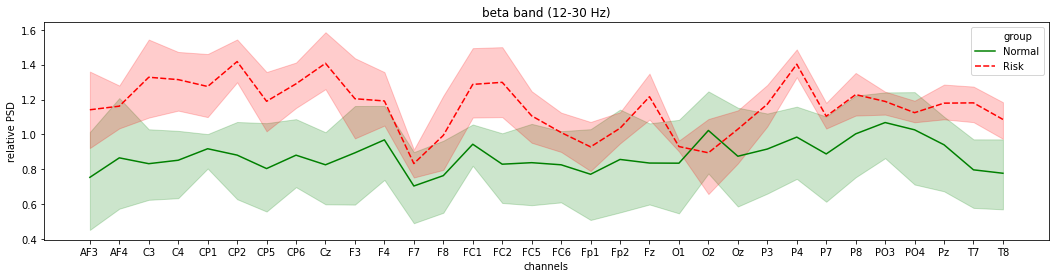

In [103]:
plot_PSD(psd_beta, 'beta band (12-30 Hz)')

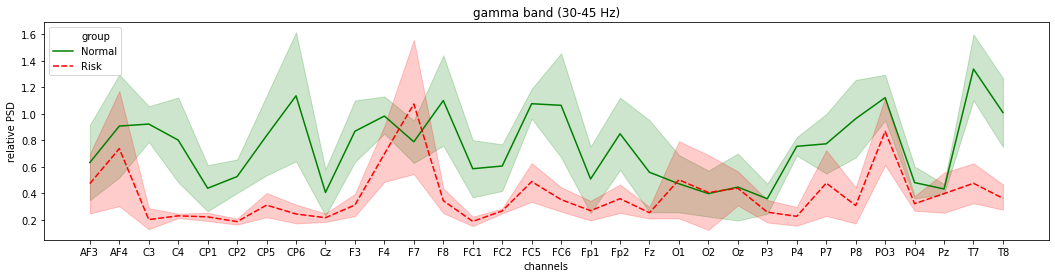

In [104]:
plot_PSD(psd_gamma, 'gamma band (30-45 Hz)')

####**2) Main effect of phase**

In [121]:
df.head()

,phase,channels,group,PSD,bands
0,IR,Fp1,Normal,0.350603,theta
1,IR,AF3,Normal,0.346808,theta
2,IR,F7,Normal,0.304496,theta
3,IR,F3,Normal,0.318335,theta
4,IR,FC1,Normal,0.301117,theta


In [0]:
def create_split_psd(band, data):
  data = data[data['bands'] == band].copy()
  data['group'] = data['phase']+'_'+data['group']
  return data.to_csv(band+'_split_psd.csv', index = False)

In [0]:
create_split_psd('theta', df)
create_split_psd('delta', df)
create_split_psd('alpha', df)
create_split_psd('beta', df)
create_split_psd('gamma', df)

In [0]:
psd_theta = pd.read_csv('theta_split_psd.csv')
psd_delta = pd.read_csv('delta_split_psd.csv')
psd_alpha = pd.read_csv('alpha_split_psd.csv')
psd_beta = pd.read_csv('beta_split_psd.csv')
psd_gamma = pd.read_csv('gamma_split_psd.csv')

In [0]:
def plot_split_PSD(data, title):
  plt.subplots(figsize = (18,4))
  sns.lineplot(x = 'channels', y = 'PSD', hue = 'group', data = data, style = 'group', palette = ['green', 'red', 'blue', 'pink'])
  plt.ylabel('relative PSD')
  plt.title(title)
  return plt.show()

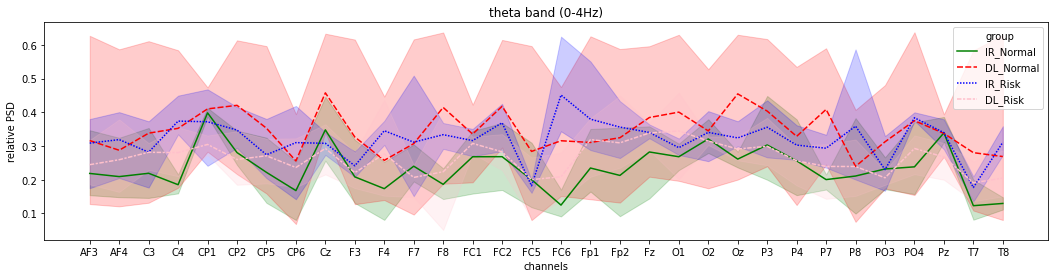

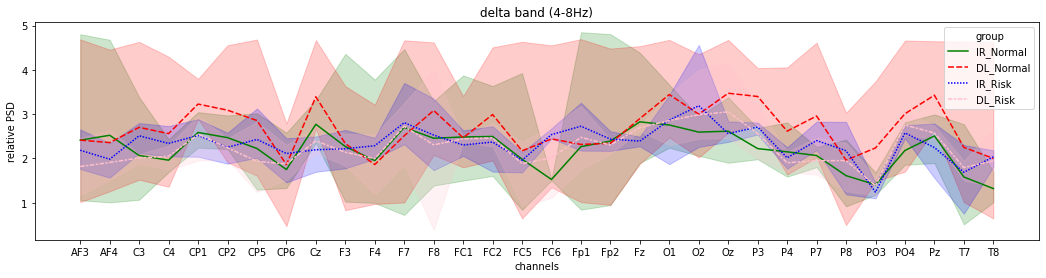

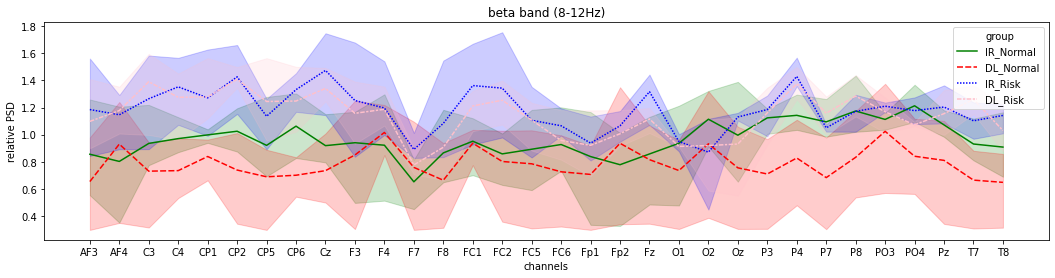

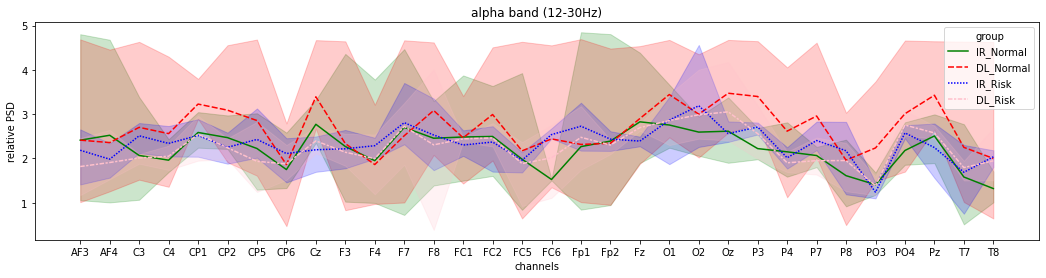

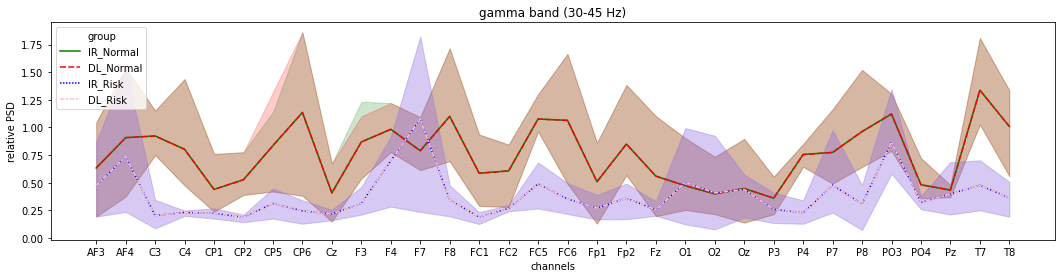

In [163]:
plot_split_PSD(psd_theta, 'theta band (0-4Hz)')
plot_split_PSD(psd_delta, 'delta band (4-8Hz)')
plot_split_PSD(psd_beta, 'beta band (8-12Hz)')
plot_split_PSD(psd_alpha, 'alpha band (12-30Hz)')
plot_split_PSD(psd_gamma, 'gamma band (30-45 Hz)')

####**3) Interaction effect of phase and group**

In [0]:
os.chdir('/content/drive/My Drive/EEG Data')
EEG_features_without_Normalize = extract_feature(['SS2','SS4','SS5','SS6','SS7','SS8'])

In [0]:
os.chdir('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA')
data = pd.read_csv('EEG_features(wo_normalize).csv')

In [179]:
data

,id,IR-PSD_Delta,IR-PSD_Theta,IR-PSD_Alpha,IR-PSD_Beta,IR-PSD_Gamma,IR-MSF,IR-SE,IR-AC,IR-wSMI_Alpha,IR-wSMI_Theta,DL-PSD_Delta,DL-PSD_Theta,DL-PSD_Alpha,DL-PSD_Beta,DL-PSD_Gamma,DL-MSF,DL-SE,DL-AC,DL-wSMI_Alpha,DL-wSMI_Theta,WCST-PSD_Delta,WCST-PSD_Theta,WCST-PSD_Alpha,WCST-PSD_Beta,WCST-PSD_Gamma,WCST-MSF
0,SS2,2.054468e-13,1.524963e-12,1.524963e-12,7.768703e-13,3.475635e-13,2.636179e-13,5.133521,0.050399,0.017202,0.044896,1.961788e-13,1.525327e-12,1.525327e-12,6.838229e-13,3.152028e-13,2.746382e-13,5.089704,0.055408,0.021856,0.040778,1.826757e-13,1.120930e-12,1.120930e-12,1.002163e-12,1.432772e-13,2.473656e-13
1,SS4,5.475750e-13,7.600708e-12,7.600708e-12,1.002692e-12,8.041770e-13,3.195261e-13,5.085171,0.044436,0.014953,0.037675,5.962930e-10,4.424420e-09,4.424420e-09,2.878444e-10,4.177453e-11,3.053830e-13,5.313078,0.056617,0.015255,0.026379,1.915302e-13,2.267646e-12,2.267646e-12,7.699860e-13,8.153512e-13,2.705664e-13
2,SS5,1.956504e-13,1.580025e-12,1.580025e-12,9.415630e-13,4.302233e-13,2.658961e-13,5.102375,0.059466,0.022325,0.046662,1.824046e-13,1.715900e-12,1.715900e-12,9.682811e-13,4.674879e-13,2.253887e-13,5.111125,0.057658,0.021963,0.048916,8.227943e-14,5.882798e-13,5.882798e-13,6.867437e-13,1.772431e-13,1.688401e-13
3,SS6,9.339271e-14,6.523108e-13,6.523108e-13,2.567939e-13,1.605897e-13,7.782025e-14,5.167918,0.052925,0.019300,0.041446,1.008870e-13,8.745897e-13,8.745897e-13,5.370193e-13,6.309129e-13,1.080997e-13,5.194672,0.057270,0.021471,0.036055,1.289384e-13,1.777061e-12,1.777061e-12,5.819538e-13,3.057082e-13,1.332754e-13
4,SS7,2.956208e-13,3.084754e-12,3.084754e-12,1.834515e-12,2.278971e-12,4.401456e-13,5.096824,0.054849,0.026467,0.036571,2.746076e-13,2.125060e-12,2.125060e-12,1.727646e-12,2.031999e-12,3.921109e-13,5.131756,0.061386,0.021612,0.039517,5.067762e-13,2.833341e-12,2.833341e-12,1.944532e-12,1.860888e-12,4.014956e-13
5,SS8,1.226531e-13,7.726978e-13,7.726978e-13,7.540438e-13,7.727883e-13,2.277611e-13,5.089492,0.067436,0.020962,0.040085,1.357951e-13,1.025221e-12,1.025221e-12,8.713561e-13,1.094194e-12,1.567857e-13,5.086812,0.062213,0.022158,0.041117,1.279403e-13,1.044803e-12,1.044803e-12,8.067324e-13,7.359509e-13,1.525775e-13


In [0]:
df = pd.DataFrame()
df['PSD_theta_chg'] = data['IR-PSD_Theta']-data['DL-PSD_Theta']
df['PSD_delta_chg'] = data['IR-PSD_Delta']-data['DL-PSD_Delta']
df['PSD_alpha_chg'] = data['IR-PSD_Alpha']-data['DL-PSD_Alpha']
df['PSD_beta_chg'] = data['IR-PSD_Beta']-data['DL-PSD_Beta']
df['PSD_gamma_chg'] = data['IR-PSD_Gamma']-data['DL-PSD_Gamma']

df['id'] = data['id'].copy()
df['group'] = ['Risk','Normal','Risk','Risk','Normal','Normal']

In [0]:
df = pd.DataFrame()
df['PSD_theta_chg'] = 10*np.log10(data['IR-PSD_Theta'].values)-10*np.log10(data['DL-PSD_Theta'].values)
df['PSD_delta_chg'] = 10*np.log10(data['IR-PSD_Delta'])-10*np.log10(data['DL-PSD_Delta'])
df['PSD_alpha_chg'] = 10*np.log10(data['IR-PSD_Alpha'])-10*np.log10(data['DL-PSD_Alpha'])
df['PSD_beta_chg'] = 10*np.log10(data['IR-PSD_Beta'])-10*np.log10(data['DL-PSD_Beta'])
df['PSD_gamma_chg'] = 10*np.log10(data['IR-PSD_Gamma'])-10*np.log10(data['DL-PSD_Gamma'])

df['id'] = data['id'].copy()
df['group'] = ['Risk','Normal','Risk','Risk','Normal','Normal']

In [0]:
data = pd.DataFrame()
data['PSD'] = np.concatenate((df['PSD_theta_chg'].values, 
                df['PSD_delta_chg'].values, 
                df['PSD_alpha_chg'].values,
                df['PSD_beta_chg'].values,
                df['PSD_gamma_chg'].values), axis = 0)
data['bands'] = ['theta']*6+['delta']*6+['alpha']*6+['beta']*6+['gamma']*6
data['group'] = ['Risk','Normal','Risk','Risk','Normal','Normal']*5

In [225]:
data['PSD'] = 10*np.log10(data['PSD'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


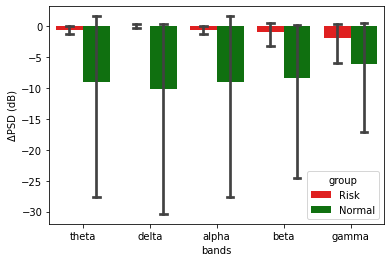

In [239]:
sns.barplot(x = 'bands', y = 'PSD', hue = 'group', data = data, capsize = 0.1, palette = ['red', 'green'])
plt.ylabel('ΔPSD (dB)')
plt.show()

###**2) Mental Workload Index**

Theta from prefrontal & frontal area divided by alpha from parietal area

In [0]:
IR_Prefrontal = IR_psd_risk[['Fp1', 'Fz', 'Fp2']]
IR_Frontal = IR_psd_risk[['FC1', 'FC5', 'FC2', 'FC6']]

DL_Prefrontal = DL_psd_risk[['Fp1', 'Fz', 'Fp2']]
DL_Frontal = DL_psd_risk[['FC1', 'FC5', 'FC2', 'FC6']]

WCST_Prefrontal = WCST_psd_risk[['Fp1', 'Fz', 'Fp2']]
WCST_Frontal = WCST_psd_risk[['FC1', 'FC5', 'FC2', 'FC6']]

In [0]:
MWI_IR = IR_Prefrontal.iloc[1,0]/IR_Frontal.iloc[2,0]
MWI_DL = DL_Prefrontal.iloc[1,0]/DL_Frontal.iloc[2,0]
MWI_WCST = WCST_Prefrontal.iloc[1,0]/WCST_Frontal.iloc[2,0]
MWI = [MWI_IR, MWI_WCST, MWI_DL]

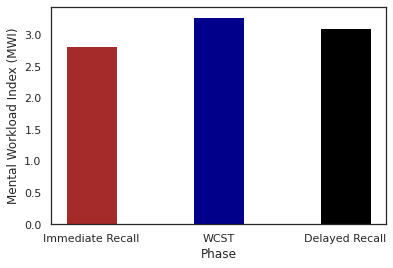

In [0]:
plt.bar(x = ['Immediate Recall', 'WCST', 'Delayed Recall'], height = MWI, width = 0.4, color = ['brown', 'darkblue', 'black'])
plt.ylabel('Mental Workload Index (MWI)')
plt.xlabel('Phase')
plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/Biomarkers/MWI of 3 phase.png')

###**3) wSMI**

# **Inferencial Statistics**

In [0]:
!pip install pingouin

In [0]:
!pip install statsmodels

In [0]:
from statsmodels.stats import anova

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from scipy import stats
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

####**Cognitive Markers**

* **Mixed ANOVA**


> IR-Total Recall and DL-Total (Within-G) & Group (Between)

In [0]:
df = pd.DataFrame()
df['group'] = pd.concat((CogMarkers['group'], CogMarkers['group']), axis = 0)
df['score'] = pd.concat((CogMarkers['IR-TotalR'],  CogMarkers['DL-TotalR']), 
                        axis = 0)
df['phase'] = None
df.iloc[0:6, 2] = 'IR-TotalR'
df.iloc[6:12, 2] = 'DL-TotalR'

df['group'].replace([0,1], ['Normal', 'Risk'], inplace = True)
df.reset_index(inplace = True)

In [0]:
anv = pg.mixed_anova(data = df, dv = 'score', within = 'phase', between = 'group', subject = 'id')
pg.print_table(anv)


ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -----  -------  -----  -------
group        12.250      1      6  12.250  2.014    0.206  0.251  nan
phase         0.250      1      6   0.250  0.333    0.585  0.053    1.000
Interaction   0.250      1      6   0.250  0.333    0.585  0.053  nan



In [0]:
posthocs = pg.pairwise_ttests(dv='score', within='phase', between='group',subject='id', effsize = 'cohen', data=df)
pg.print_table(posthocs)


POST HOC TESTS

Contrast       phase      A          B          Paired    Parametric         T    dof  Tail         p-unc    BF10    cohen
-------------  ---------  ---------  ---------  --------  ------------  ------  -----  ---------  -------  ------  -------
phase          -          IR-TotalR  DL-TotalR  True      True          -0.607  7.000  two-sided    0.563   0.392   -0.128
group          -          Normal     Risk       False     True           1.419  6.000  two-sided    0.206   0.893    1.003
phase * group  IR-TotalR  Normal     Risk       False     True           1.760  6.000  two-sided    0.129   1.132    1.244
phase * group  DL-TotalR  Normal     Risk       False     True           1.029  6.000  two-sided    0.343   0.706    0.728



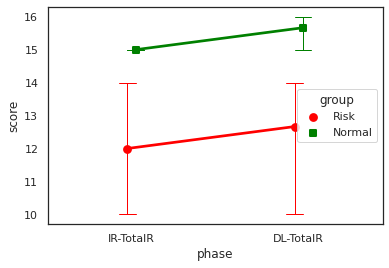

In [259]:
sns.set(style = 'white')
sns.pointplot(data=df, x='phase', y='score', hue='group', dodge=True, markers=['o', 's'],
	      capsize=.1, errwidth=1, palette = ['red','green'], grid = False)



> %IR-FreeR, %IR-CuedR, %DL-FreeR, %DL-CuedR (within) & Group (Between)



In [0]:
cog_m =CogMarkers.copy()
cog_m['IR-FreeR'] = (CogMarkers['IR-FreeR'])/16
cog_m['IR-CuedR'] = (CogMarkers['IR-CuedR'])/(16-CogMarkers['IR-FreeR'])
cog_m['DL-FreeR'] = (CogMarkers['DL-FreeR'])/16
cog_m['DL-CuedR'] = (CogMarkers['DL-CuedR'])/(16-CogMarkers['DL-FreeR'])

cog_m['group'] = pd.Categorical(cog_m['group'])

In [0]:
df = pd.DataFrame()
df['group'] = pd.concat((cog_m['group'], cog_m['group'], cog_m['group'], cog_m['group']), axis = 0)
df['score'] = pd.concat((cog_m['IR-FreeR'],  cog_m['IR-CuedR'], cog_m['DL-FreeR'],  cog_m['DL-CuedR']), 
                        axis = 0)
df['phase'] = None
df.iloc[0:6, 2] = 'IR-FreeR'
df.iloc[6:12, 2] = 'IR-CuedR'
df.iloc[12:18, 2] = 'DL-FreeR'
df.iloc[18:24, 2] = 'DL-CuedR'

df['group'].replace([0,1], ['Normal', 'Risk'], inplace = True)
df.reset_index(inplace = True)

In [0]:
anv = pg.mixed_anova(data = df, dv = 'score', within = 'phase', between = 'group', subject = 'id')
pg.print_table(anv)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
group        0.108      1      6  0.108   1.569    0.257  0.207  nan
phase        0.331      3     18  0.110  15.737    0.000  0.724    0.858
Interaction  0.060      3     18  0.020   2.864    0.066  0.323  nan



In [0]:
posthocs = pg.pairwise_ttests(dv='score', within='group', between='phase',subject='id', effsize = 'cohen', data=df)
pg.print_table(posthocs)


POST HOC TESTS

Contrast       group    A         B         Paired    Parametric         T     dof  Tail         p-unc    BF10    cohen
-------------  -------  --------  --------  --------  ------------  ------  ------  ---------  -------  ------  -------
group          -        Normal    Risk      True      True           2.221  15.000  two-sided    0.042   1.715    0.659
phase          -        IR-FreeR  IR-CuedR  False     True          -2.372  14.000  two-sided    0.033   2.316   -1.186
phase          -        IR-FreeR  DL-FreeR  False     True           0.000  14.000  two-sided    1.000   0.428    0.000
phase          -        IR-FreeR  DL-CuedR  False     True          -2.573  14.000  two-sided    0.022   3.003   -1.287
phase          -        IR-CuedR  DL-FreeR  False     True           2.500  14.000  two-sided    0.025   2.729    1.250
phase          -        IR-CuedR  DL-CuedR  False     True          -0.501  14.000  two-sided    0.624   0.466   -0.250
phase          -       

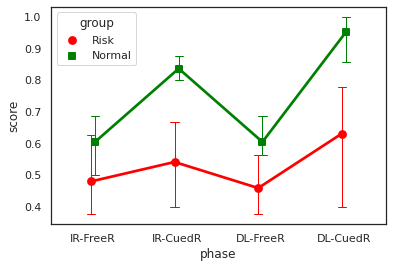

In [256]:
sns.set(style = 'white')
sns.pointplot(data=df, x='phase', y='score', hue='group', dodge=True, markers=['o', 's'],
	      capsize=.1, errwidth=1, palette = ['red','green'], grid = False)

* **Multiple Regression**

In [0]:
reg = pg.linear_regression(X = cog_m[['IR-FreeR','IR-CuedR','DL-FreeR','DL-CuedR','MoCA']], y = cog_m['group'])
pg.print_table(reg)

names        coef     se       T    pval     r2    adj_r2    CI[2.5%]    CI[97.5%]
---------  ------  -----  ------  ------  -----  --------  ----------  -----------
Intercept   1.816  0.835   2.175   0.162  0.856     0.498      -1.776        5.407
IR-FreeR    2.634  1.973   1.335   0.314  0.856     0.498      -5.857       11.125
IR-CuedR   -1.536  1.428  -1.076   0.395  0.856     0.498      -7.680        4.608
DL-FreeR    0.894  1.988   0.450   0.697  0.856     0.498      -7.658        9.445
DL-CuedR   -2.203  1.582  -1.393   0.298  0.856     0.498      -9.009        4.602
MoCA       -0.031  0.025  -1.222   0.346  0.856     0.498      -0.141        0.078



* **Logistic Regression**

In [0]:
X = pd.concat((per_cog_risk[['IR-FreeR','DL-FreeR']], 
               per_cog_normal[['IR-FreeR',	'DL-FreeR']]), axis = 0)
y = pd.concat((per_cog_risk[['group']], 
               per_cog_normal[['group']]), axis = 0)

In [0]:
regressor = LogisticRegression()
regressor.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

* SVM

In [0]:
clf = SVC()
clf.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
plt.figure(1, figsize = (4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color = 'black')

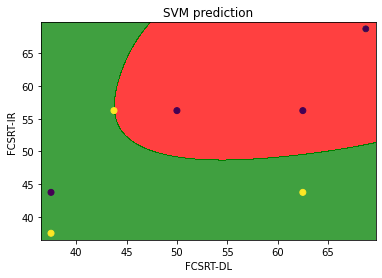

In [0]:
from matplotlib.colors import ListedColormap
X_set, y_set = X, y
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, 
             clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))

plt.scatter(X_set[:,0], X_set[:,1], c = y)
plt.title('SVM prediction')
plt.xlabel('FCSRT-DL')
plt.ylabel('FCSRT-IR')
plt.show()

##**Biomarkers**

####**1) Overall Test** 
Q: Are PSDs in electrode really difference within 2 phase?
* Channels (Within)
* Group (Between)
* Phase (Within)
* PSD (DV)

A: Mixed ANOVA (3-Way mixed ANOVA run in R)

In [0]:
#Create PSD factor
df = pd.DataFrame(data = None, columns = ['phase', 'channels', 'group', 'PSD'])
def concat_PSD(data):
  PSD = []
  PSD_t = []
  for i in range(len(data)):
    PSD = data.iloc[i,:32].values
    PSD_t = np.concatenate((PSD_t, PSD), axis = 0)
  return PSD_t

PSD_IR_normal = concat_PSD(IR_psd_normal) #32x3
PSD_DL_normal = concat_PSD(DL_psd_normal) #32x3
PSD_WCST_normal = concat_PSD(WCST_psd_normal) #32x3
PSD_IR_risk = concat_PSD(IR_psd_risk) #32x3
PSD_DL_risk = concat_PSD(DL_psd_risk) #32x3
PSD_WCST_risk = concat_PSD(WCST_psd_risk)
PSD = np.concatenate((PSD_IR_normal,PSD_DL_normal,PSD_WCST_normal,PSD_IR_risk,PSD_DL_risk,PSD_WCST_risk), axis = 0)
PSD.shape

group = ['Normal']*288+['Risk']*288
phase = ['IR']*96+['WCST']*96+['DL']*96+['IR']*96+['WCST']*96+['DL']*96
ID = ['SS4']*32+['SS7']*32+['SS8']*32+['SS4']*32+['SS7']*32+['SS8']*32+['SS4']*32+['SS7']*32+['SS8']*32+['SS2']*32+['SS5']*32+ ['SS6']*32+['SS2']*32+['SS5']*32+ ['SS6']*32+['SS2']*32+['SS5']*32+ ['SS6']*32

df['group'] = group
df['phase'] = phase
df['id'] = ID
df['PSD'] = PSD
df['channels'] = chn_names*18

In [0]:
df.tail()

,phase,channels,group,PSD,id
571,DL,F8,Risk,1.200096,SS6
572,DL,AF4,Risk,1.238341,SS6
573,DL,Fp2,Risk,1.722976,SS6
574,DL,Fz,Risk,1.973305,SS6
575,DL,Cz,Risk,2.072594,SS6


In [0]:
#In order to run 3 way mixed ANOVA, samples data need to be matched.

In [0]:
df2 = df[df['phase'] == 'IR']
df2 = pd.concat((df2, df[df['phase'] == 'DL']), axis = 0)

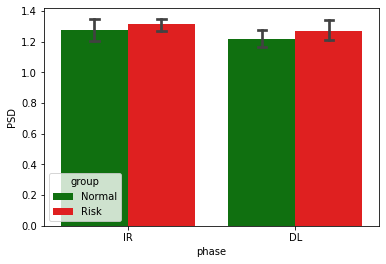

In [0]:
sns.barplot(x = 'phase', y = 'PSD', data = df2, hue = 'group', palette = ['green', 'red'], capsize = 0.05, saturation = 0.75)

Text(0, 0.5, 'relative PSD')

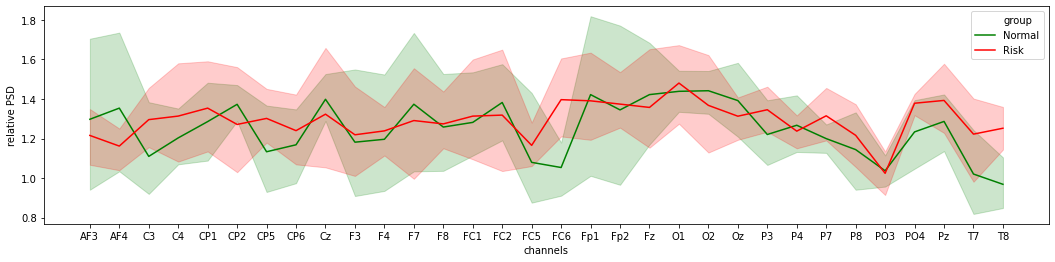

In [0]:
plt.subplots(figsize= (18,4))
sns.lineplot(x = 'channels', y = 'PSD', data = df2, hue = 'group', palette = ['green', 'red'])
plt.ylabel('relative PSD')

####**2) Time-Frequency Test**
Q: Are PSDs of each group changed along with trials?
* Bands (Within)
* Phase (Within)
* PSD (DV)

A: 3 Repeated Measure ANOVA models, risk, normal, & both groups.

In [0]:
#Design DataFrame
df = pd.DataFrame()
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
bio_m = Biomarkers.iloc[:, [1,2,3,4,5,11,12,13,14,15,21,22,23,24,25]]
df = pd.DataFrame(bio_m.stack())
df.reset_index(inplace = True)
df['group'] = None

for x in Biomarkers.index:
  if x in ['SS2', 'SS5', 'SS6']:
    df.loc[df['id']== x, 'group'] = 1
  else:
    df.loc[df['id']== x, 'group'] = 0

df['bands'] = bands*18
phase = ['IR','IR','IR','IR','IR','DL','DL','DL','DL','DL','WCST','WCST','WCST','WCST','WCST']
df['phase'] = phase*6
df.drop(['level_1'], axis = 1, inplace = True)
df.rename({0:'PSD'}, inplace = True, axis = 1)

In [0]:
sns.lineplot()

,id,PSD,group,bands,phase
0,SS2,0.313125,1,delta,IR
1,SS2,2.355038,1,theta,IR
2,SS2,2.355038,1,alpha,IR
3,SS2,1.277359,1,beta,IR
4,SS2,0.388560,1,gamma,IR


1) All-in

In [0]:
rm_anv = pg.rm_anova(data = df, dv = 'PSD', within = ['phase', 'bands'], subject = 'id', detailed = True)
pg.print_table(rm_anv)


ANOVA SUMMARY

Source             SS    ddof1    ddof2      MS       F    p-unc    p-GG-corr    np2    eps
-------------  ------  -------  -------  ------  ------  -------  -----------  -----  -----
phase           0.231        2       10   0.116   0.703    0.518        0.449  0.123  0.543
bands          61.522        4       20  15.381  42.595    0.000        0.000  0.895  0.325
phase * bands   1.029        8       40   0.129   0.884    0.539        0.392  0.150  0.127



/usr/local/lib/python3.6/dist-packages/pingouin/distribution.py:464: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


In [0]:
posthocs = pg.pairwise_ttests(dv='PSD', within='phase', between='bands',subject='id', data=df)
pg.print_table(posthocs)


POST HOC TESTS

Contrast       phase    A      B      Paired    Parametric         T     dof  Tail         p-unc      BF10    hedges
-------------  -------  -----  -----  --------  ------------  ------  ------  ---------  -------  --------  --------
phase          -        IR     DL     True      True          -0.836  29.000  two-sided    0.410     0.268    -0.056
phase          -        IR     WCST   True      True           0.868  29.000  two-sided    0.392     0.275     0.076
phase          -        DL     WCST   True      True           0.907  29.000  two-sided    0.372     0.283     0.125
bands          -        delta  theta  False     True          -9.767  10.000  two-sided    0.000  4913.406    -5.205
bands          -        delta  alpha  False     True          -9.767  10.000  two-sided    0.000  4913.406    -5.205
bands          -        delta  beta   False     True          -8.351  10.000  two-sided    0.000  1460.780    -4.450
bands          -        delta  gamma  False    

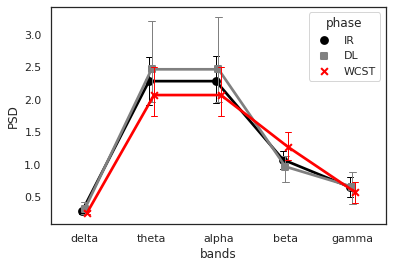

In [0]:
#Total
sns.set(style = 'white')
sns.pointplot(data=df, x='bands', y='PSD', hue='phase', dodge=True, markers=['o', 's', 'x'],
	      capsize=.1, errwidth=1, palette = ['black','grey','red'], grid = False)

2) Risk group

In [0]:
r = df[df['group'] == 1] 
anv = pg.rm_anova(data = r, dv = 'PSD', within = ['bands', 'phase'], effsize = 'np2', subject = 'id')
pg.print_table(anv)


ANOVA SUMMARY

Source             SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr    np2    eps
-------------  ------  -------  -------  -----  ------  -------  -----------  -----  -----
bands          31.453        4        8  7.863  59.354    0.000        0.010  0.967  0.298
phase           0.028        2        4  0.014   0.131    0.881        0.752  0.061  0.500
bands * phase   0.270        8       16  0.034   0.327    0.943        0.654  0.140  0.077



/usr/local/lib/python3.6/dist-packages/pingouin/distribution.py:464: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


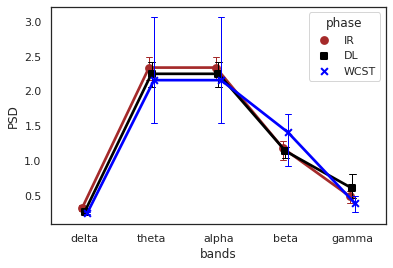

In [0]:
sns.set(style = 'white')
sns.pointplot(data=r, x='bands', y='PSD', hue='phase', dodge=True, markers=['o', 's', 'x'],
	      capsize=.1, errwidth=1, palette = ['brown','black','blue'], grid = False)

3) Normal Group

In [0]:
n = df[df['group'] == 0] 
anv = pg.rm_anova(data = n, dv = 'PSD', within = ['bands', 'phase'], effsize = 'np2', subject = 'id')
pg.print_table(anv)


ANOVA SUMMARY

Source             SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr    np2    eps
-------------  ------  -------  -------  -----  ------  -------  -----------  -----  -----
bands          30.754        4        8  7.688  11.229    0.002        0.078  0.849  0.251
phase           0.374        2        4  0.187   0.719    0.541        0.488  0.264  0.516
bands * phase   1.356        8       16  0.170   0.759    0.642        0.526  0.275  0.073



/usr/local/lib/python3.6/dist-packages/pingouin/distribution.py:464: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


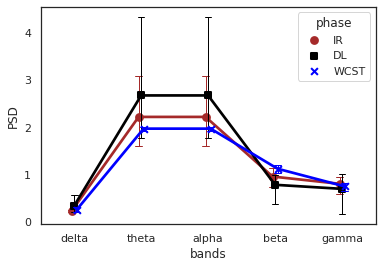

In [0]:
sns.set(style = 'white')
sns.pointplot(data=n, x='bands', y='PSD', hue='phase', dodge=True, markers=['o', 's', 'x'],
	      capsize=.1, errwidth=1, palette = ['brown','black', 'blue'], grid = False)

In [0]:
def plot_compare(col_1, col_2, y):
  y = y
  df = pd.DataFrame()
  data = []
  data_t = []
  list_variable = [col_1, col_2]
  for i in list_variable:
    data = Biomarkers.loc[:, i].values
    data_t = np.concatenate((data_t, data), axis = 0)

  group = ['Risk','Normal','Risk','Risk','Normal','Normal']*2
  id = ['SS2', 'SS4', 'SS5', 'SS6', 'SS7', 'SS8']*2

  df['id'] = id
  df['group'] = group
  df[y] = data_t
  df['phase'] = ['IR']*6+['DL']*6

  fig = sns.barplot(data = df, x = 'phase', y = y, hue = 'group', palette = ['red', 'green'], capsize = 0.05, saturation = 0.75)
  return fig

###**3) etc. graph**

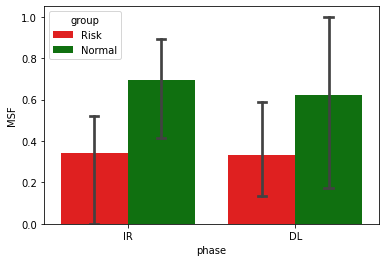

In [244]:
plot_compare('IR-MSF', 'DL-MSF', 'MSF')

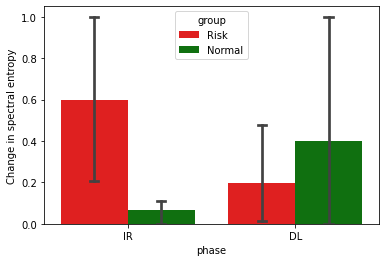

In [245]:
plot_compare('IR-SE', 'DL-SE', 'Change in spectral entropy')

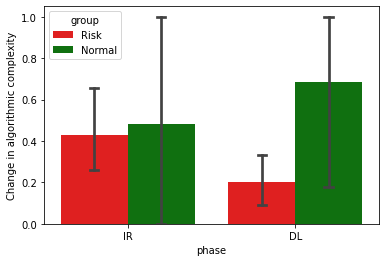

In [246]:
plot_compare('IR-AC', 'DL-AC', 'Change in algorithmic complexity')

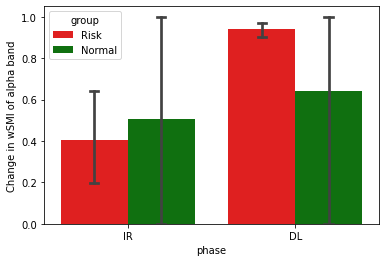

In [247]:
plot_compare('IR-wSMI_Alpha', 'DL-wSMI_Alpha', 'Change in wSMI of alpha band')

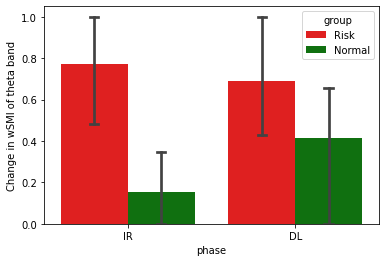

In [248]:
plot_compare('IR-wSMI_Theta', 'DL-wSMI_Theta', 'Change in wSMI of theta band')

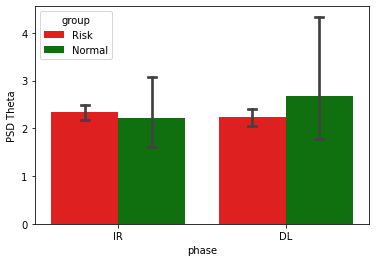

In [0]:
plot_compare('IR-PSD_Theta', 'DL-PSD_Theta', 'PSD Theta')

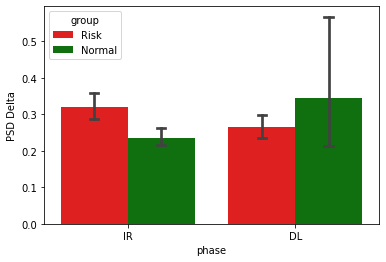

In [0]:
plot_compare('IR-PSD_Delta', 'DL-PSD_Delta', 'PSD Delta')

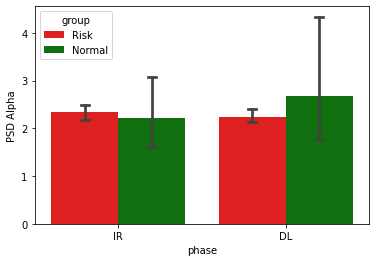

In [0]:
plot_compare('IR-PSD_Alpha', 'DL-PSD_Alpha', 'PSD Alpha')

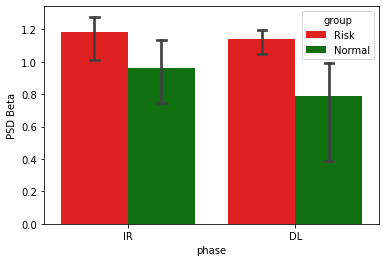

In [0]:
plot_compare('IR-PSD_Beta', 'DL-PSD_Beta', 'PSD Beta')

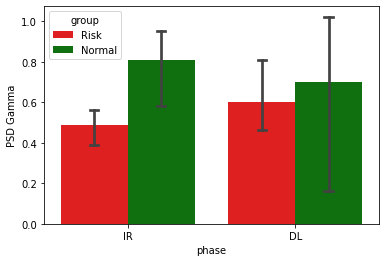

In [0]:
plot_compare('IR-PSD_Gamma', 'DL-PSD_Gamma', 'PSD Gamma')
plt.show()